In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, logistic, uniform
from statsmodels.nonparametric.kernel_regression import KernelReg  

In [0]:
np.random.seed(42) # seed is used to make the result reproducible

rng_min = 0
rng_max = 1000
step = 20

x = np.arange(rng_min, rng_max, step) # independent variable
var = 0.1 + 5*x**2    # non-constant variance
b = 6                    # intercept
m = 5                 # slope

# normal random errors with non-constant variance
sz = (rng_max - rng_min)//step
err = norm.rvs(loc = 0, scale = np.sqrt(var), size=sz)

y = m*x + b + err

x_sub = x[0:len(x):5]
y_sub = y[0:len(y):5]

490.0 2098.7508068439092


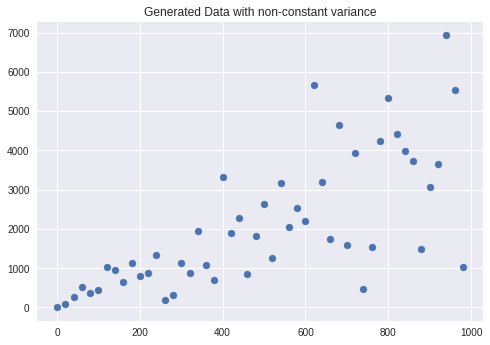

In [220]:
plt.scatter(x, y)
plt.title('Generated Data with non-constant variance')
print(np.mean(x), np.mean(y))

But as x increases, the mean of y given x becomes less meaningful. As a predictor of y it’s pretty useless. 

But what about a quantile, like the 0.90 quantile?

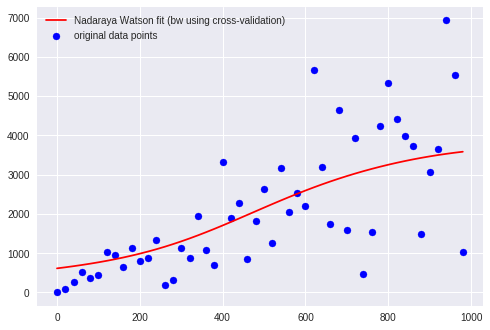

In [221]:
# 1) NW estimator

NW_model = KernelReg(endog = y, exog = x, var_type = 'c', reg_type = 'lc')
#NW_model = KernelReg(endog = y_sub, exog = x_sub, var_type = 'c', reg_type = 'lc')

fig, ax = plt.subplots(1,1)

ax.scatter(x, y, color = 'blue', label = 'original data points')
ax.plot(x, NW_model.fit()[0], color = 'red', label = 'Nadaraya Watson fit (bw using cross-validation)')
#ax.plot(x_sub, NW_model.fit()[0], color = 'red', label = 'Nadaraya Watson fit (bw using cross-validation)')

ax.legend(loc=2, frameon=False)


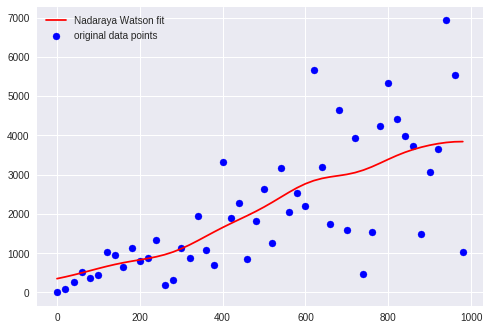

In [222]:
# 2) NW estimator (choose bw manually)

import math

def gaus_ker(x):  
  return (1/np.sqrt(2*math.pi))*np.exp(-0.5*(x**2))

def NW_pred(x, y, data_xpred, bw):
  
  ker_x = np.zeros(len(x))
  
  for i in range(len(x)):
    ker_x[i] = gaus_ker((x[i]-data_xpred)/bw)  
  
  G_numer = (ker_x * y).sum(axis=0)
  G_denom = ker_x.sum(axis=0)
  return G_numer / G_denom

def my_NW_model(x, y, bw):
  my_pred = np.zeros(len(x))
  for i in range(len(x)):  
    my_pred[i] = NW_pred(x, y, x[i], bw)
    
  return my_pred

bw = 200

fig, ax = plt.subplots(1,1)

ax.scatter(x, y, color = 'blue', label = 'original data points')
ax.plot(x, my_NW_model(x, y, bw=80), color = 'red', label = 'Nadaraya Watson fit')
#ax.plot(x_sub, my_NW_model(x_sub, y_sub, bw=bw), color = 'red', label = 'Nadaraya Watson fit (choose bw manually)')
ax.legend(loc=2, frameon=False)

Ideally, the fit should have gone upwards gradually, but we observe that towards the end, it bent slightly downwards because of the presence of outliers. Thus, it is NOT able to capture the trend of the data appropriately.

In [0]:
from scipy.optimize import minimize

def sum_q_est(x, y, data_xpred, theta, alpha, bw):
  sum = 0
  for i in range(len(x)):
    sum+=(abs(y[i]-theta) + (2*alpha-1)*(y[i]-theta))*gaus_ker((x[i]-data_xpred)/bw)
                 
  return sum

alpha = np.arange(0.1, 1, 0.1)
y_pred = np.zeros((len(alpha), len(x)))
#y_pred = np.zeros((len(alpha), len(x_sub)))

"\nax.plot(x_sub, y_pred[0], color = 'purple', label = 'Local constant quantile fit for 0.1 th quantile')\nax.plot(x_sub, y_pred[1], color = 'orange', label = 'Local constant quantile fit for 0.2 th quantile')\nax.plot(x_sub, y_pred[2], color = 'green', label = 'Local constant quantile fit for 0.3 th quantile')\nax.plot(x_sub, y_pred[3], color = 'red', label = 'Local constant quantile fit for 0.4 th quantile')\nax.plot(x_sub, y_pred[4], color = 'black', label = 'Local constant quantile fit for 0.5 th quantile')\nax.plot(x_sub, y_pred[5], color = 'red', label = 'Local constant quantile fit for 0.6 th quantile')\nax.plot(x_sub, y_pred[6], color = 'green', label = 'Local constant quantile fit for 0.7 th quantile')\nax.plot(x_sub, y_pred[7], color = 'orange', label = 'Local constant quantile fit for 0.8 th quantile')\nax.plot(x_sub, y_pred[8], color = 'purple', label = 'Local constant quantile fit for 0.9 th quantile')\n"

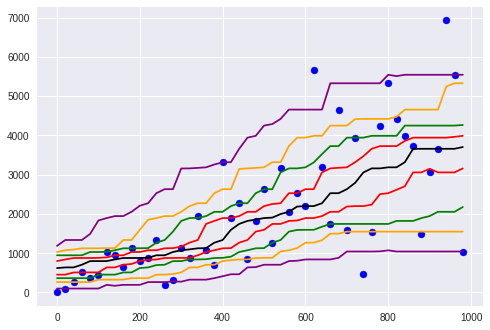

In [224]:
bw = 200

for j in range(len(alpha)):
  for i in range(len(x)):
  #for i in range(len(x_sub)):
    fun = lambda theta: sum_q_est(x, y, x[i], theta, alpha[j], bw)
    #fun = lambda theta: sum_q_est(x_sub, y_sub, x_sub[i], theta, alpha[j], bw)
    y_pred[j][i] = minimize(fun, 10).x            

fig, ax = plt.subplots(1,1)

ax.scatter(x, y, color = 'blue', label = 'original data points')

ax.plot(x, y_pred[0], color = 'purple', label = 'Local constant quantile fit for 0.1 th quantile')
ax.plot(x, y_pred[1], color = 'orange', label = 'Local constant quantile fit for 0.2 th quantile')
ax.plot(x, y_pred[2], color = 'green', label = 'Local constant quantile fit for 0.3 th quantile')
ax.plot(x, y_pred[3], color = 'red', label = 'Local constant quantile fit for 0.4 th quantile')
ax.plot(x, y_pred[4], color = 'black', label = 'Local constant quantile fit for 0.5 th quantile')
ax.plot(x, y_pred[5], color = 'red', label = 'Local constant quantile fit for 0.6 th quantile')
ax.plot(x, y_pred[6], color = 'green', label = 'Local constant quantile fit for 0.7 th quantile')
ax.plot(x, y_pred[7], color = 'orange', label = 'Local constant quantile fit for 0.8 th quantile')
ax.plot(x, y_pred[8], color = 'purple', label = 'Local constant quantile fit for 0.9 th quantile')

"""
ax.plot(x_sub, y_pred[0], color = 'purple', label = 'Local constant quantile fit for 0.1 th quantile')
ax.plot(x_sub, y_pred[1], color = 'orange', label = 'Local constant quantile fit for 0.2 th quantile')
ax.plot(x_sub, y_pred[2], color = 'green', label = 'Local constant quantile fit for 0.3 th quantile')
ax.plot(x_sub, y_pred[3], color = 'red', label = 'Local constant quantile fit for 0.4 th quantile')
ax.plot(x_sub, y_pred[4], color = 'black', label = 'Local constant quantile fit for 0.5 th quantile')
ax.plot(x_sub, y_pred[5], color = 'red', label = 'Local constant quantile fit for 0.6 th quantile')
ax.plot(x_sub, y_pred[6], color = 'green', label = 'Local constant quantile fit for 0.7 th quantile')
ax.plot(x_sub, y_pred[7], color = 'orange', label = 'Local constant quantile fit for 0.8 th quantile')
ax.plot(x_sub, y_pred[8], color = 'purple', label = 'Local constant quantile fit for 0.9 th quantile')
"""

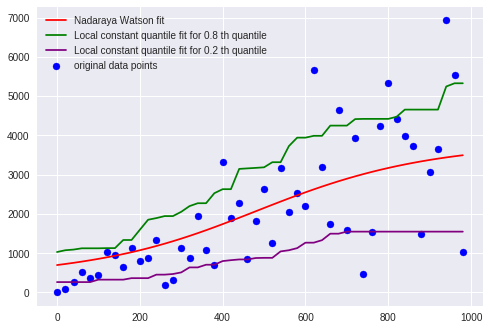

In [225]:
fig, ax = plt.subplots(1,1)

ax.scatter(x, y, color = 'blue', label = 'original data points')

ax.plot(x, my_NW_model(x, y, bw=200), color = 'red', label = 'Nadaraya Watson fit')
ax.plot(x, y_pred[7], color = 'green', label = 'Local constant quantile fit for 0.8 th quantile')
ax.plot(x, y_pred[1], color = 'purple', label = 'Local constant quantile fit for 0.2 th quantile')

ax.legend(loc=2, frameon=False)

These 2 quantiles are able to capture the trend of increasing variance of data really well!!